In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [5]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset(
    data_root='../data/BIOQIC',
    data_name='phantom',
    xyz_slice='2D',
    frequency=80
)
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Loading ../data/BIOQIC/phantom_elastogram.npy
     <class 'numpy.ndarray'> (8, 128, 80, 25) complex128
Loading ../data/BIOQIC/phantom_regions.npy
     <class 'numpy.ndarray'> (128, 80, 25) int64
Preprocessing data
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, component: 2, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 80.0
  * component       (component) <U1 'z' 'y'
    z               float64 0.0
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y            

<xarray.Dataset>
Dimensions:         (frequency: 1, component: 2, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 80.0
  * component       (component) <U1 'z' 'y'
    z               float64 0.0
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y               (y) float64 0.0 0.0015 0.003 0.0045 ... 0.1155 0.117 0.1185
    spatial_region  (x, y) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
Data variables:
    a               (frequency, x, y, component) float64 0.0 0.0 ... 43.0 51.62
    u               (frequency, x, y, component) complex128 (220.249352672487...
    mu              (frequency, x, y) complex128 0j 0j 0j 0j 0j ... 0j 0j 0j 0j
    Ku              (frequency, x, y, component) complex128 (147.901568860227...
    Lu              (frequency, x, y, component) complex128 (-121863218.20257...
    Mu              (frequency, x, y) complex128 (1070.8930123387477+657.6933...

<IPython.core.display.Javascript object>


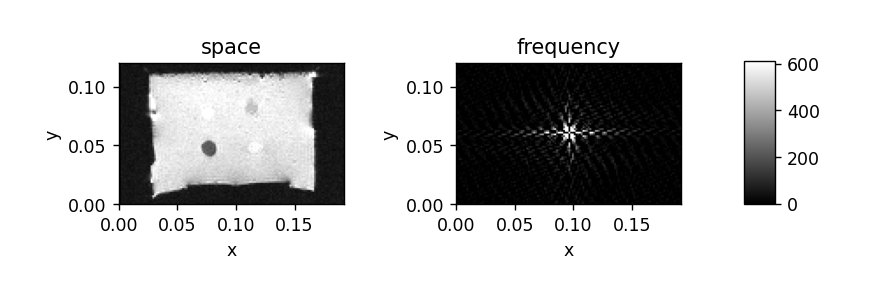

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


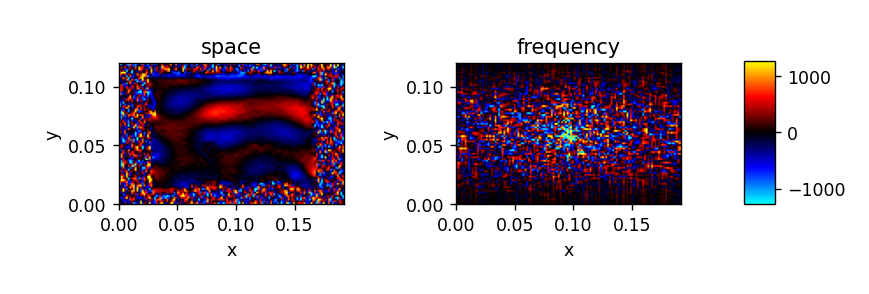

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


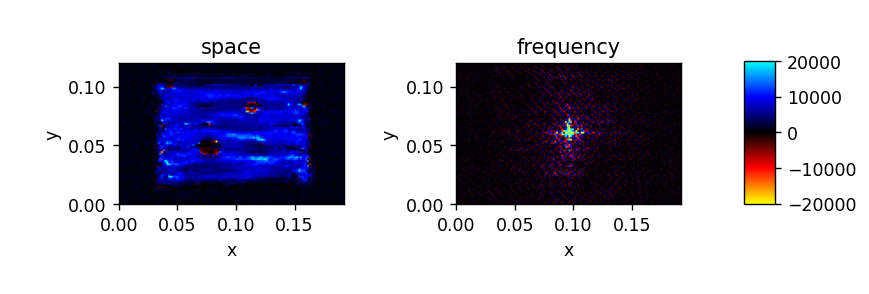

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


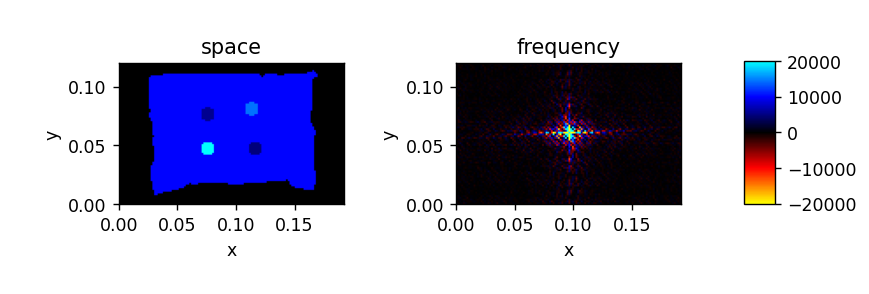

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

In [6]:
%autoreload

# configure color maps
anat_kws = mre_pinn.visual.get_color_kws(data.a)
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

# display true wave field and elastogram
y = 'y' if 'y' in data.field.spatial_dims else None
hue = None if 'y' in data.field.spatial_dims else 'part'
mre_pinn.visual.XArrayViewer(data.a,  col='domain', hue=None, ax_width=2, **anat_kws)
mre_pinn.visual.XArrayViewer(data.u,  col='domain', hue=None, ax_width=2, **wave_kws)
#mre_pinn.visual.XArrayViewer(data.Lu, col='domain', y=y, hue=None, ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), col='domain', hue=None, ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), col='domain', hue=None, ax_width=2, **elast_kws)

In [7]:
%autoreload

net = mre_pinn.pinn.ParallelPINN(
    n_inputs=[data.field.n_spatial_dims + 1, data.field.n_spatial_dims],
    n_outputs=[data.field.n_spatial_dims, 1],
    omega0=1,
    n_layers=5,
    n_hidden=128,
    activ_fn='s',
    dense=True,
    polar=False,
    conditional=True,
    dtype=torch.float32
)
net

ParallelPINN(
  (net0): PINN(
    (input_scaler): InputScaler()
    (linear0): Linear(in_features=5, out_features=128, bias=True)
    (linear1): Linear(in_features=133, out_features=128, bias=True)
    (linear2): Linear(in_features=261, out_features=128, bias=True)
    (linear3): Linear(in_features=389, out_features=128, bias=True)
    (linear4): Linear(in_features=517, out_features=4, bias=True)
    (output_scaler): OutputScaler()
  )
  (net1): PINN(
    (input_scaler): InputScaler()
    (linear0): Linear(in_features=5, out_features=128, bias=True)
    (linear1): Linear(in_features=133, out_features=128, bias=True)
    (linear2): Linear(in_features=261, out_features=128, bias=True)
    (linear3): Linear(in_features=389, out_features=128, bias=True)
    (linear4): Linear(in_features=517, out_features=2, bias=True)
    (output_scaler): OutputScaler()
  )
)

In [8]:
%autoreload
pde = mre_pinn.pde.WaveEquation.from_name('hetero', detach=True)
pde

Compiling model...
'compile' took 0.000234 s

Training model...



<IPython.core.display.Javascript object>


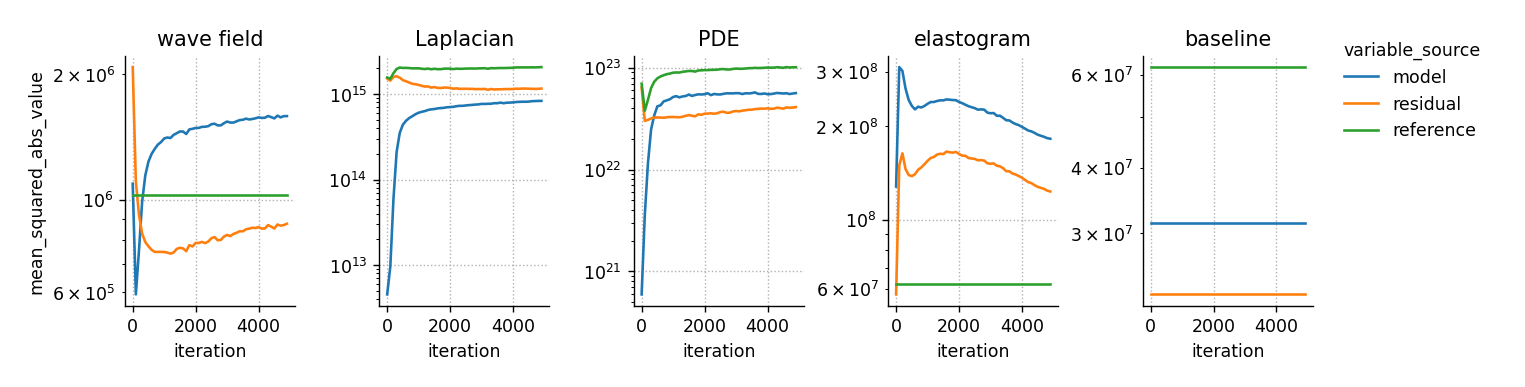

<IPython.core.display.Javascript object>


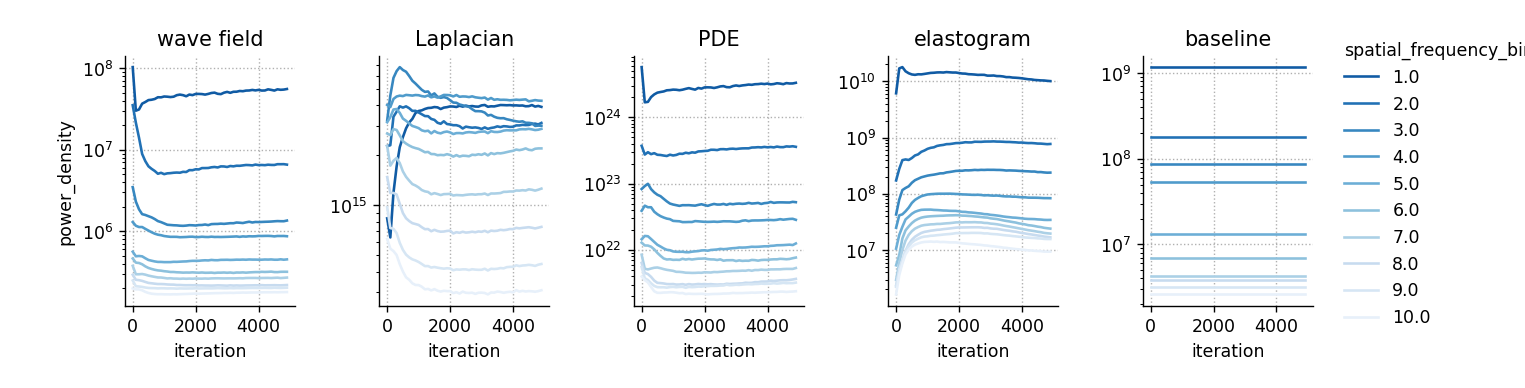

<IPython.core.display.Javascript object>


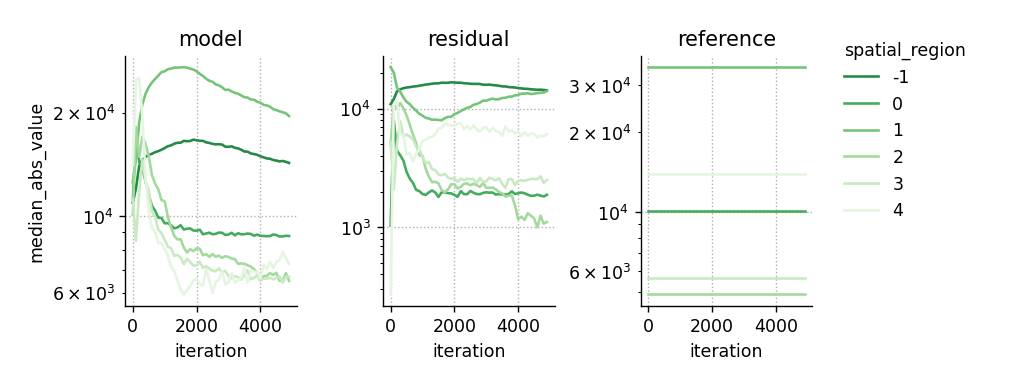

<IPython.core.display.Javascript object>


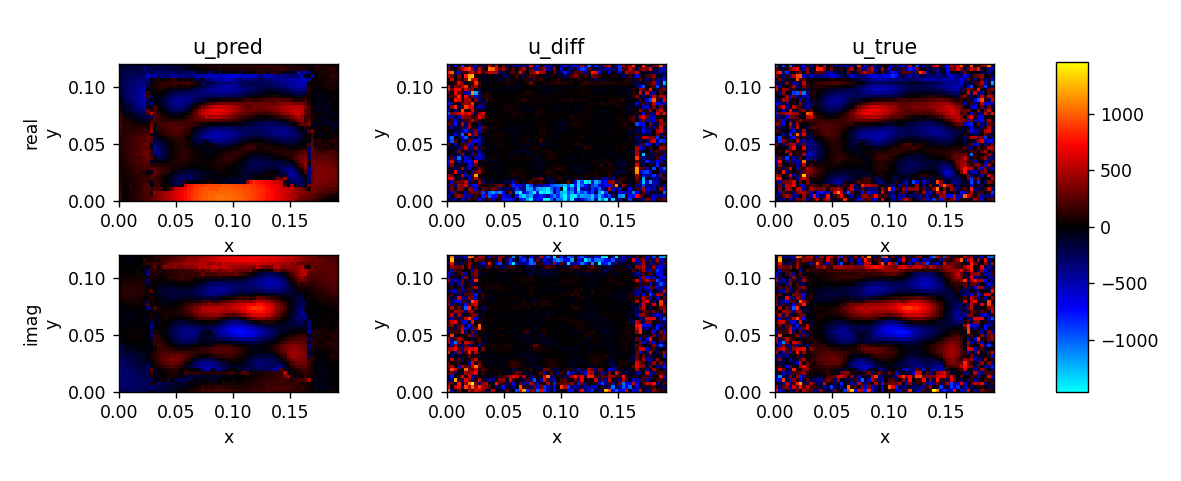

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


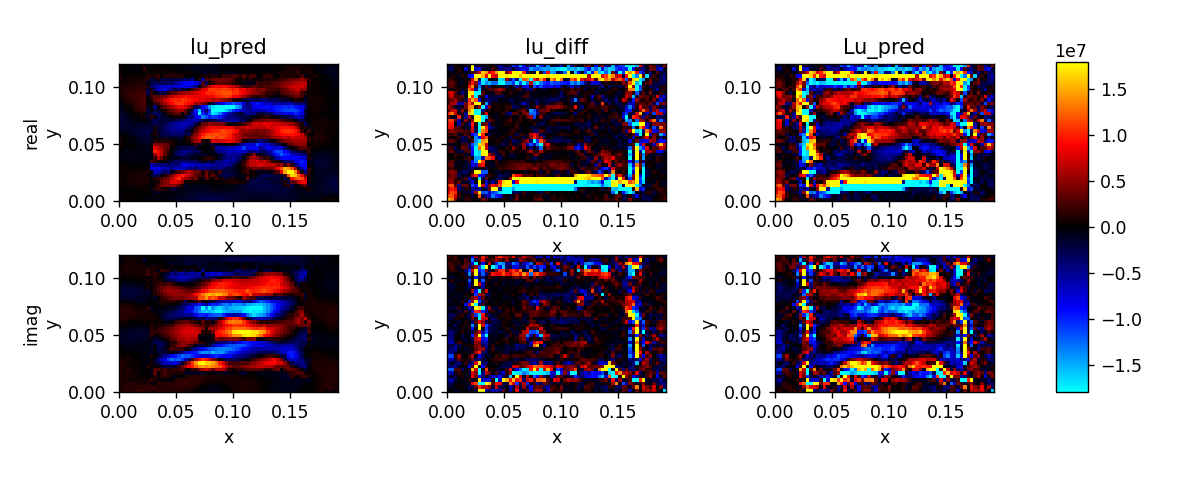

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


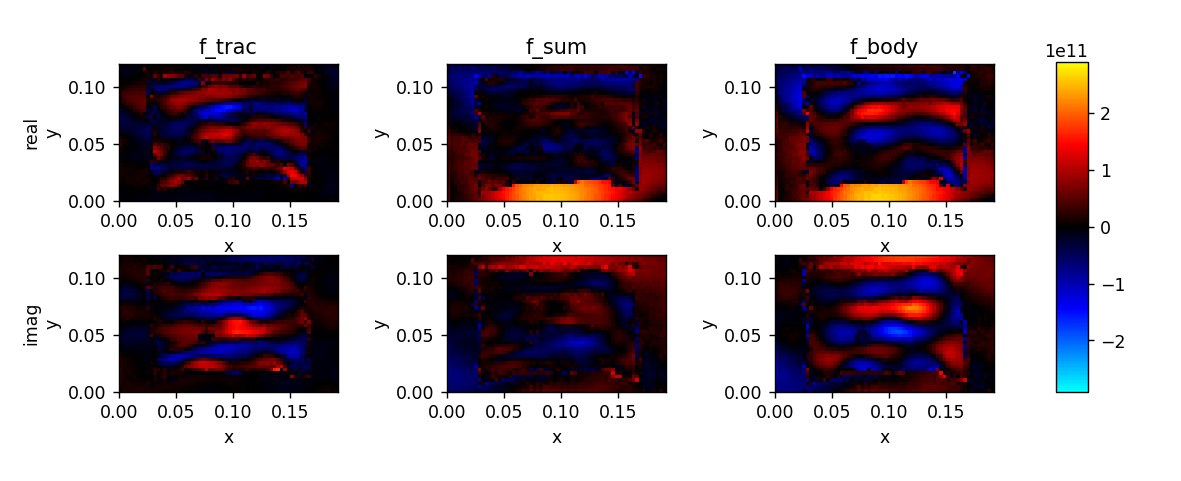

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


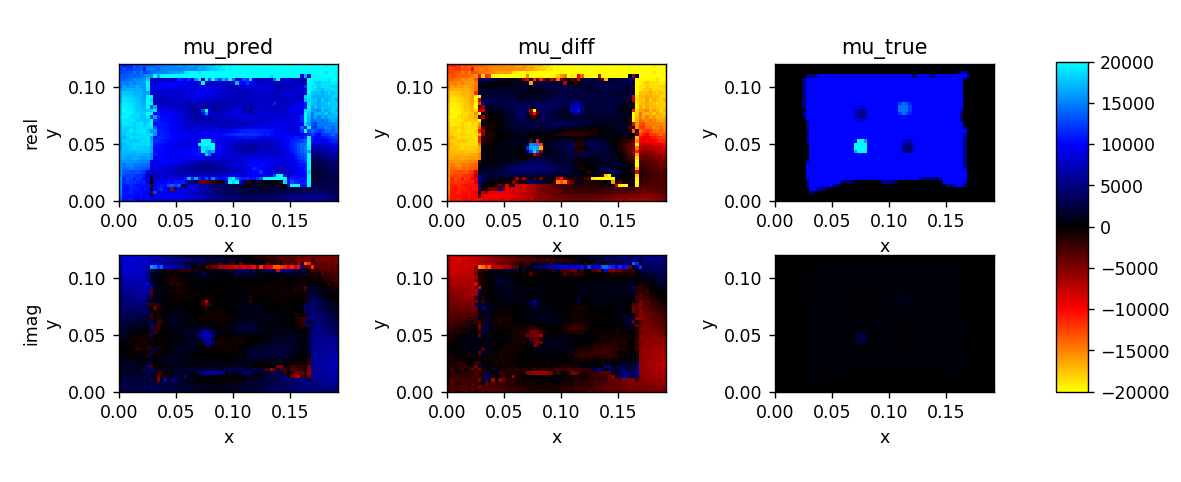

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


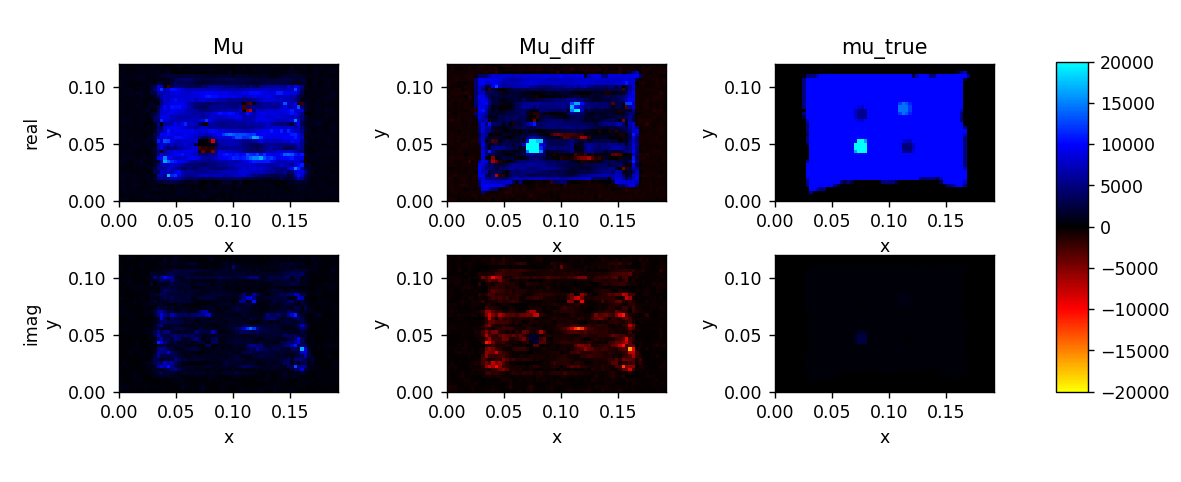

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 40.93%
Time spent testing: 35.42%
Time spent testing: 32.51%
Time spent testing: 30.94%
Time spent testing: 30.00%
Time spent testing: 29.39%
Time spent testing: 28.94%
Time spent testing: 28.57%
Time spent testing: 28.31%
Time spent testing: 28.32%
Time spent testing: 28.13%
Time spent testing: 28.00%
Time spent testing: 27.87%
Time spent testing: 27.76%
Time spent testing: 27.79%
Time spent testing: 27.82%
Time spent testing: 27.84%
Time spent testing: 27.87%
Time spent testing: 28.03%
Time spent testing: 28.05%
Time spent testing: 28.08%
Time spent testing: 28.11%
Time spent testing: 28.14%
Time spent testing: 28.17%
Time spent testing: 28.20%
Time spent testing: 28.23%
Time spent testing: 28.25%
Time spent testing: 28.36%
Time spent testing: 28.38%
Time spent testing: 28.39%
Time spent testing: 28.41%
Time spent testing: 28.42%
Time spent testing: 28.44%
Time spent testing: 28.45%
Time spent testing: 28.47%
Time spent testing: 28.48%
Time spent testing: 28.50%
T

In [10]:
%autoreload

model = mre_pinn.training.PINNModel(data, net, pde, batch_size=128)
model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1, 1e-8],
    loss=mre_pinn.training.standardized_msae_loss_fn(data.u.values)
)
deepxde.display.training_display = mre_pinn.training.SummaryDisplay()

test_eval = mre_pinn.testing.TestEvaluator(
    test_data, model, batch_size=None, test_every=100, save_every=1000, interact=True
)
try:
    model.train(5000, display_every=10, callbacks=[test_eval])
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)